In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Creating Mocks
#### Raw data in format:
- 0: Time (ms)
- 1: bus voltage (V)
- 2-5: cell 1-4 voltage
- 6: current (mA)
- 7: shunt voltage (mV)

In [53]:
# Generate mocking files:
def generate_mock(input_array, line_nums_226, file_name_226, line_nums_3221, file_name_3221, curr_index, min_curr=0):
    start_row = 0
    if min_curr != 0:
        current_curr = 0
        while current_curr < min_curr:
            start_row += 1
            current_curr = float(input_array[start_row][curr_index])
            
    np.savetxt(file_name_226, input_array[start_row:, line_nums_226], "%s", ",")
    np.savetxt(file_name_3221, input_array[start_row:, line_nums_3221], "%s", ",")

In [54]:
for file_num in range (28, 35):
    with open(fr"..\raw\{file_num}.csv") as F:
        lines = [line.strip().split(',') for line in F.readlines()]

    results = np.array(lines)
    generate_mock(results, [0,1,-2], fr"..\mocks\ina_mock_{file_num}.csv", [2,3,4,5], fr"..\mocks\ina3221_mock_{file_num}.csv", 6, 1500)

## Plotting results
#### Mocks are in format:  
INA226 Mock:
- 0: Time (ms)
- 1: Voltage (V)
- 2: Shunt voltage (mV)

INA3221 Mock:
- 0-3: Cell Voltage (V)

#### Outputs are in format:
- 0: Time (ms)
- 1: Voltage (V)
- 2: Sim voltage (V)
- 3: Fitted sim voltage (V)
- 4: Est flight time (s)
- 5: Est flight time remaining (s)
- 6: Est capacity (Ah)
- 7: Est usable capacity (Ah)
- 8: Used capacity (mAh)
- 9: Adjusted used capacity (mAh)
- 10: Used energy (mWh)
- 11: Adjusted used energy (mWh)
- 12-15: Cell performance values
- 13: resistance estimate (Ohms)

In [2]:
ina226_index_lookup = ['Time (ms)', 'Voltage (V)', 'Shunt Voltage (mV)']
ina3221_index_lookup = ['Cell 0 Voltage (V)', 'Cell 1 Voltage (V)', 'Cell 2 Voltage (V)', 'Cell 3 Voltage (V)']
output_index_lookup = ['Time (ms)', 'Voltage (V)', 'Sim Voltage (V)',
                  'Fitted Sim Voltage (V)', 'Est Flight Time (s)',
                  'Est Flight Time Remaining (s)', 'Est Capacity (Ah)',
                  'Est Usable Capacity (Ah)', 'Used Capacity (mAh)',
                  'Adjusted Used Capacity (mAh)', 'Used Energy (mWh)',
                  'Adjusted Used Energy (mWh)', 'Cell 0 Performance',
                  'Cell 1 Performance', 'Cell 2 Performance',
                  'Cell 3 Performance', 'Resistance Estimate (Ohms)']

In [3]:
def import_csv_and_convert(file_path):
    with open(file_path, "r") as F:
        lines = [[float(elt) for elt in line.strip().split(',') if elt.strip()] for line in F.readlines()]
        
    return np.array(lines)

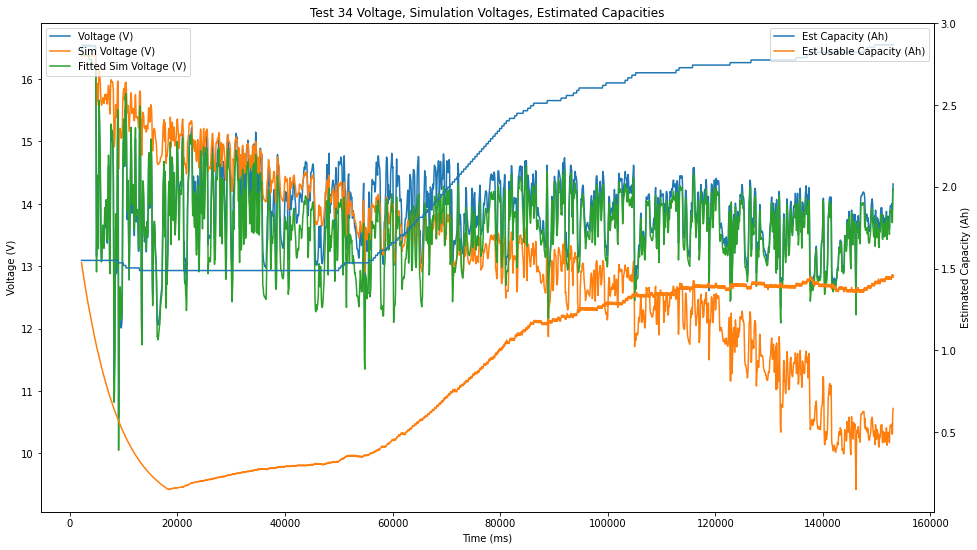

In [38]:
def plot_simulations(INA226_file_path, INA3221_file_path, output_file_path, INA_indices, INA3221_indices, output_indices, title="",
                    other_INA_indices=[], other_INA3221_indices=[], other_output_indices=[]):
    INA_data = import_csv_and_convert(INA226_file_path)
    INA3221_data = import_csv_and_convert(INA3221_file_path)
    output_data = import_csv_and_convert(output_file_path)
    
    fig, ax1 = plt.subplots(figsize=(16, 9))
    ax2 = 0
    twinx = False
    
    def plot_indices(indices, data, lookup, x=0, ax=0, twinx=False, ax2=0):
        
        for index in indices:
            if index < len(data[0]):
                if x == 1:
                    if twinx != True:
                        ax2 = ax.twinx()
                        ax2.set_ylabel('Estimated Capacity (Ah)')
                        twinx = True
                        
                    ax2.plot(output_data[:-5, 0], data[:-5, index], label=lookup[index])
                    ax2.legend(loc='upper right')
                else:
                    ax1.plot(output_data[:-5, 0], data[:-5, index], label=lookup[index])
        
        if twinx:
            return (True, ax2)
        else:
            return (False, 0)
    
    def generate_title(indices, lookup):
        output = []
        
        for index in indices:
            if index < len(lookup):
                output.append(lookup[index])
                
        return output

    plot_indices(output_indices, output_data, output_index_lookup)
    plot_indices(INA_indices, INA_data, ina226_index_lookup)
    plot_indices(INA3221_indices, INA3221_data, ina3221_index_lookup)
    
    twinx, ax2 = plot_indices(other_output_indices, output_data, output_index_lookup, 1, ax1, twinx, ax2)
    twinx, ax2 = plot_indices(other_INA_indices, INA_data, ina226_index_lookup, 1, ax1, twinx, ax1)
    twinx, ax2 = plot_indices(other_INA3221_indices, INA3221_data, ina3221_index_lookup, 1, ax1, twinx, ax2)
    
    if title == "":
        title_parts = []
        title_parts += generate_title(output_indices, output_index_lookup)
        title_parts += generate_title(INA_indices, ina226_index_lookup)
        title_parts += generate_title(INA3221_indices, ina3221_index_lookup)
        title = ', '.join(title_parts)
    
    ax1.set_title(title)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend(loc='upper left')
    plt.show()

run_num = 34
plot_simulations(fr"..\testing-inputs\ina_mock_{run_num}.csv", fr"..\testing-inputs\ina3221_mock_{run_num}.csv",
                 fr"..\testing_outputs\{run_num}-output.csv",
                 [], [], [1,2,3],
                f"Test {run_num} Voltage, Simulation Voltages, Estimated Capacities",
                [], [], [6,7])